### Software pre-requisites

In [2]:
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import torch  # 2.0 or greater
    from torch.func import vmap
    from torch import nn
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    import torch.nn.functional as F
    from torch.nn import MSELoss
    from torch.cuda import amp
    import pickle as pkl
    
    print("All packages are installed!")
except ImportError as e:
    print(f"An error occurred: {e}. Please make sure all required packages are installed.")

from typing import Callable
import math

device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 60
criterion = MSELoss()
dim_MNIST = 28

All packages are installed!
cpu


### Pre-processing

In [2]:
# Define the transformation to apply to the images (e.g., convert them to tensors)
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: 2*x - 1)])

# Load the MNIST training dataset
mnist_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
# Create data loaders for training and testing datasets
mnist_loader = DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=True)

#Test image
img, label = next(iter(mnist_dataset))
print(label)

5


In [ ]:
def grab(var):
    return var.detach().cpu().numpy()


def change_color(img, patch): #Mettre du jaune
    """
    Change the color on a patch of the image.
    """
    if img.shape[1] == 1:
        img = img.repeat(1, 3, 1, 1)
    Idx = torch.where(patch == 1)

    img[:, 0, Idx[0], Idx[1]] = 236/255 #Add red
    img[:, 1, Idx[0], Idx[1]] = 230/255 #Add green
    img[:, 2, Idx[0], Idx[1]] = 255/255 #Add blue
    
    return img

### Prior distribution

In [5]:
from torch.distributions import MultivariateNormal

class BaseDistribution:
    def __init__(self, mean: torch.Tensor, cov: torch.Tensor, device=device): 
        self.mean = mean
        self.covariance = cov
        self.distribution = MultivariateNormal(mean.to(device), cov.to(device))
    
    def sample(self, n: int=1):
        """
        Draws $n$ samples from the Gaussian distribution.
        """
        return self.distribution.sample((n,)).reshape(n, 1, dim_MNIST, dim_MNIST)
    
    def log_prob(self, x: torch.Tensor):
        """
        Evaluates the log probability of given samples $x$ under the distribution. 
        """
        return self.distribution.log_prob(x)

dim = img.reshape(-1).shape[0]
mean = torch.zeros(dim)  # \mu \in R^2
cov = torch.eye(dim)  # \Sigma \in R^{2x2}

base = BaseDistribution(mean, cov)

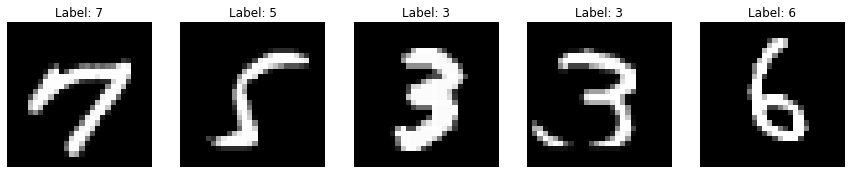

In [6]:
images, labels = next(iter(mnist_loader))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Get the ith image and reshape it to 28x28
    img = images[i].reshape(dim_MNIST, dim_MNIST)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Label: {labels[i]}')
    axes[i].axis('off')  # Hide the axes
plt.show()

In [ ]:
import random

def target(n, dataset=mnist_dataset, device=device):
    # Randomly sample n indices from the dataset
    indices = random.sample(range(len(dataset)), n)
    # Use list comprehension to gather images and labels for these indices
    images = torch.stack([dataset[i][0] for i in indices])    
    return images.to(device)

In [ ]:
class Interpolant:
    def _single_xt(self, x0, x1, alpha):
        if len(alpha.shape) != len(x0.shape):
            alpha = alpha.reshape(*x0.shape)
        return alpha*x0 + (1 - alpha)*x1
    
    def _single_dtxt(self, x0, x1):
        return x0 - x1

    def xt(self, x0, x1, alpha):
        if len(alpha.shape) != len(x0.shape):
            alpha = alpha.reshape(*x0.shape)
        return vmap(self._single_xt, in_dims=(0, 0, 0))(x0,x1,alpha)
    
    def dtxt(self, x0, x1):
        return vmap(self._single_dtxt, in_dims=(0, 0))(x0,x1)
    
interpolant = Interpolant()

### Manual Interpolation between data and noise

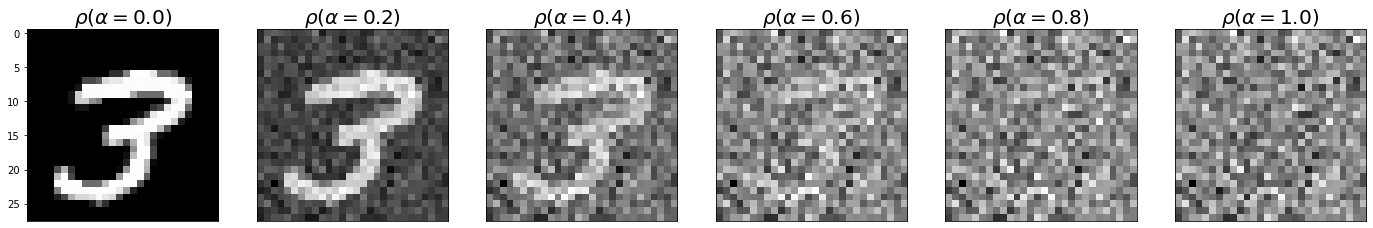

In [9]:
bs = 1
ncol = 6
ts   = torch.linspace(0, 1, ncol)
x0s = base.sample(bs)
x1s = target(bs)
fig, axes = plt.subplots(1, ncol, figsize=(ncol*4,4))
Alpha = torch.cat((ts[:,None],)*dim, axis = 1)

for i, alpha in enumerate(Alpha):
    
    alpha  = alpha.repeat(bs, 1).to(device).reshape(*x1s[0].shape)
    xts = interpolant.xt(x0s, x1s, alpha)
    
    axes[i].imshow(xts.reshape(dim_MNIST, dim_MNIST).to("cpu"), cmap='gray')
    axes[i].set_xticks([])
    axes[i].set_title(r'$\rho(\alpha = %.1f)$' % alpha[0, 0, 0].item(), fontsize = 20, weight='bold')
    
    if i !=0:
        axes[i].set_yticks([])

del x0s; del x1s; del Alpha

### Neural Network $\hat b_t(x)$ to model $b_t(x)$

Now we need to define a neural network which has learnable parameters to model $b_t(x)$. Recall that the velocity field takes in a time coordinate and a spatial sample which is $\mathbb R^2$. This means that our neural network approximation $\hat b_t(x)$ should be a function that has an input size of $1 + \text{space dim} = 3$ and should have an output dimension of $\text{space dim} = 2$. We'll use the U-NET architecture below.

To define a neural network, we'll use PyTorch's `torch.nn.Module` library which allows us to compose parts of the neural network in a way that allows us to take derivatives with respect to the networks weights:

In [10]:
# This is the utils file
def zero_out(layer):
    for p in layer.parameters():
        p.detach().zero_()
    return layer

# AdaGN according to paper "Diffusion Models Beat GANs on Image Synthesis"
class AdaNorm(nn.Module):
    def __init__(self, num_channel: int):
        super().__init__()
        num_group = int(num_channel/16) # According to group norm paper, 16 channels per group produces the best result
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor, emb: torch.Tensor):
        scale, shift = torch.chunk(emb, 2, dim=1)
        tensor = self.gnorm(tensor)
        tensor = tensor * (1 + scale) + shift
        return tensor


class MyGroupNorm(nn.Module):
    def __init__(self, num_channel: int):
        super().__init__()
        num_group = int(num_channel/16) # According to group norm paper, 16 channels per group produces the best result
        self.gnorm = nn.GroupNorm(num_group, num_channel, affine=False)

    def forward(self, tensor: torch.Tensor):
        return self.gnorm(tensor)

        
class ResBlock(nn.Module):
    def __init__(self, in_channel: int, out_channel: int, emb_dim: int = 1024, up: bool = False, down: bool = False):
        super().__init__()
        self.emb = nn.Sequential(nn.SiLU(), nn.Linear(emb_dim, 2*out_channel))
        if up:
            self.change_size = nn.Upsample(scale_factor=2, mode='nearest')
        elif down:
            self.change_size = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            self.change_size = nn.Identity()

        # Normalization
        self.gnorm1 = MyGroupNorm(in_channel)
        self.gnorm2 = AdaNorm(out_channel)

        # Convolution
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size = 3, padding = 1)
        if in_channel != out_channel:
            self.conv3 = nn.Conv2d(in_channel, out_channel, kernel_size = 1)
        else:
            self.conv3 = nn.Identity()

        # Combine input stage
        self.input = nn.Sequential(
            self.gnorm1,
            nn.SiLU(),
            self.change_size,
            self.conv1
        )

        # Combine output stage
        self.output = nn.Sequential(
            nn.SiLU(),
            zero_out(self.conv2)
        )

        # Skip connection
        self.skip_connection = nn.Sequential(
            self.change_size,
            self.conv3
        )

        # Embedding
        self.embed = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, 2 * out_channel)
        )

    def forward(self, tensor: torch.Tensor, emb: torch.Tensor):
        emb = self.embed(emb).view(tensor.shape[0], -1, 1, 1)

        h = self.input(tensor)
        h = self.gnorm2(h, emb)
        h = self.output(h)
        x = self.skip_connection(tensor)

        return x + h

class SelfAttention(nn.Module):
    def __init__(self, channel: int):
        super().__init__()
        self.num_head = int(channel/32)

    def forward(self, tensor: torch.Tensor):
        batch, channel, length = tensor.shape
        ch = channel // 3 // self.num_head
        q, k, v = tensor.chunk(3, dim = 1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        # The code below is from Diffusion Model Beat GANs on Image Synthesis paper code
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(batch * self.num_head, ch, length),
            (k * scale).view(batch * self.num_head, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(batch * self.num_head, ch, length))
        return a.reshape(batch, -1, length)


class Attention(nn.Module):
    def __init__(self, channel: int):
        super().__init__()
        self.gnorm = MyGroupNorm(channel)
        self.qkv = nn.Conv1d(channel, channel * 3, 1)
        self.attention = SelfAttention(channel)
        self.output = zero_out(nn.Conv1d(channel, channel, 1))

    def forward(self, tensor: torch.Tensor):
        # Perform self attention
        batch, channel, width, height = tensor.shape
        tensor = tensor.reshape(batch, channel, -1)
        # Skip connection
        tensor_skip = tensor
        tensor = self.gnorm(tensor)
        tensor = self.qkv(tensor)
        tensor = self.attention(tensor)
        tensor = self.output(tensor)

        # Adding the skip connection tensor back to the current tensor
        tensor = tensor + tensor_skip

        tensor = tensor.reshape(batch, channel, width, height)
        return tensor


class UNet(nn.Module):
    def __init__(self, image_channel: int = 1, depth: int = 2, emb_dim: int = 1024):
        super().__init__()

        # Create model architecture
        channels = [160, 320, 544, 608]
        attention_channel = [544, 608]
        self.encoder = nn.ModuleList([nn.ModuleList([nn.Conv2d(image_channel, channels[0], 3, padding=1)])])
        self.decoder = nn.ModuleList()

        skip_channel = [channels[0]]

        # Encoder
        for i in range(len(channels)):
            for _ in range(depth):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channel:
                    layer.append(Attention(channels[i]))
                self.encoder.append(layer)
                skip_channel.append(channels[i])

            if i != len(channels)-1:
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i], channels[i + 1], down=True, emb_dim = emb_dim))
                self.encoder.append(layer)
                skip_channel.append(channels[i+1])

        # Bottleneck
        self.bottle_neck = nn.ModuleList([
            ResBlock(channels[-1], channels[-1], emb_dim = emb_dim),
            Attention(channels[-1]),
            ResBlock(channels[-1], channels[-1], emb_dim = emb_dim),
        ])

        # Decoder
        for i in range(len(channels)-1, -1, -1):
            for block in range(depth+1):
                layer = nn.ModuleList()
                layer.append(ResBlock(channels[i] + skip_channel.pop(), channels[i], emb_dim = emb_dim))
                if channels[i] in attention_channel:
                    layer.append(Attention(channels[i]))

                if i != 0 and block == depth:
                    layer.append(ResBlock(channels[i], channels[i - 1], up=True, emb_dim = emb_dim))

                self.decoder.append(layer)

        # Create time embedding
        self.time_embedding = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        # Output kernels to change back to image channel
        self.out = nn.Sequential(
            MyGroupNorm(channels[0]),
            nn.SiLU(),
            zero_out(nn.Conv2d(channels[0], image_channel, 3, padding=1)),
        )

    def forward(self, tensor: torch.Tensor, time_embedding: torch.Tensor):
        # Creating embedding
        embedding = self.time_embedding(time_embedding)
        
        skip_connection = []

        # Encoder
        for layer in self.encoder:
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

            skip_connection.append(tensor)

        # Bottleneck
        for module in self.bottle_neck:
            if(isinstance(module, ResBlock)):
                tensor = module(tensor, embedding)
            else:
                tensor = module(tensor)

        # Decoder
        for layer in self.decoder:
            P = skip_connection.pop()
            if P.shape[-1] == tensor.shape[-1] + 1:
                tensor= F.pad(tensor, (1, 0, 1, 0), "constant", 0) 

            tensor = torch.concatenate((tensor, P), dim = 1)
            for module in layer:
                if(isinstance(module, ResBlock)):
                    tensor = module(tensor, embedding)
                else:
                    tensor = module(tensor)

        tensor = self.out(tensor)

        return tensor


class VelocityFieldImage(nn.Module):
    def __init__(self, init_features=dim_MNIST, device='cpu'):
        super(VelocityFieldImage, self).__init__()
        # Increment the input channels by 1 to accommodate the alpha dimension
        self.unet = UNet(image_channel = 1, depth = 2, emb_dim = init_features**2).to(device)

    def forward(self, x, alpha):
        """
        Important Note: alpha should be a linear vector, and not a matrix.
        """
        return self.unet(x, alpha)

class ODE:
    def __init__(self, b: VelocityFieldImage, interpolant: Interpolant, n_step: int, Alpha: torch.Tensor = None, mask: torch.Tensor = None, device: str = device):
        """
        Attributes:
            b: VectorField. Generator of the flow.
            interpolant: Interpolant. This is the interpolant between source and target distribution.
            n_step: int. Step size for the resolution of the ODE.
            Alpha : Tensor. It is the trajectory in the alpha-space of the stochastic interpolant.
            mask: Tensor. Mask the generator for the non-corrupted entries.
        """
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        self.device = device
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*dim, axis = 1)
        else:
            self.alpha = Alpha
        self.dt          = 1/n_step
        if mask is None:
            self.mask = torch.ones(self.alpha.shape[-1], device = device)
        else:
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

    def step(self, x: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
        mask = self.mask.reshape(*x.shape[1:])
        gen = self.b(x, alpha)
        return x - mask*gen*self.dt
    
    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        xs = torch.zeros((self.n_step, *x_init.shape), device = device)
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(len(x), 1) #Repeat for each batch size
            x = self.step(x, alpha)
            xs[i] = x
        return xs

### Sanity check

In [11]:
b = VelocityFieldImage(init_features=dim_MNIST, device=device)

N = 8
x = target(N)

alpha = torch.rand(N, *x[0].shape).to(device).reshape(N, -1)

# print(x.shape)
# print(alpha.shape)

output = b(x, alpha)
print(torch.linalg.norm(output).item())

alpha = alpha.requires_grad_(True)
print(alpha.requires_grad)
del output; del alpha; del x

0.0
True


### Loss function

In [12]:
def loss_fn(b, interpolant, x0, x1, alpha):
    """
    Interpolant loss function for a single datapoint of (x0, x1, t).
    """
    It   = interpolant.xt(x0, x1, alpha)
    dtIt = interpolant.dtxt(x0, x1)
    bt          = b.forward(It, alpha)
    loss        = criterion(bt, dtIt)
    return loss


N = 10
x0s = base.sample(N)
x1s = target(N)
alpha = torch.rand(N, *x1s[0].shape).to(device).reshape(N, -1)
l = loss_fn(b, interpolant, x0s, x1s, alpha)
print(l.mean().item())
del alpha; del x1s; del x0s

1.961225986480713


#### Training step

Now that we have constructed our loss, let's put it in a loop to interatively update the parameters of $\hat b$ and $\hat \eta_t(x)$ as we move toward the minimizer of $\mathcal L_b[\hat b]$ and $\mathcal L_\eta[\hat \eta]$. 

To perform this parameter update, we need to introduce a pytorch `optimizer` that performs the gradient update for us. We do that via the following, specifying a learning rate `lr`. We use the `Adam` optimizer, which is a fancier version of SGD.

Now lets use it in a function called `train_step` which will perform our iteration:

In [ ]:
def train_step(b, interpolant, opt, sched, scaler):
    ## Training
    
    #Set the neural network to training mode
    b.train()
    # evaluate train loss
    for x1s, _ in mnist_loader:
        opt.zero_grad()
        x1s = x1s.to(device)
        x0s = base.sample(batch_size)
        alpha = torch.rand(batch_size, 1).to(device).repeat(1, dim_MNIST*dim_MNIST) #Training on the hypercube
        # alpha = torch.rand(batch_size, 28*28, device = device)
    
        with amp.autocast():
            loss_train = loss_fn(b, interpolant, x0s, x1s, alpha)/batch_size
        # perform backprop
        scaler.scale(loss_train).backward() #Scale the loss
        torch.nn.utils.clip_grad_norm_(b.parameters(), max_norm = 1.0) #Clip the norm of the gradients
        scaler.step(opt) #Update the parameters' gradient
        scaler.update()
    sched.step()
    
    ##Validation
    
    #Set the neural network to evaluation mode
    b.eval()
    
    x0s_eval = base.sample(batch_size)
    x1s_eval = target(batch_size)
    # alpha_eval = torch.rand(batch_size, 1).to(device).repeat(1, 28*28)
    alpha_eval = torch.rand(batch_size, dim_MNIST*dim_MNIST, device = device)
    with amp.autocast():
        #Evaluate loss on validation dataset
        loss_eval = loss_fn(b, interpolant, x0s_eval, x1s_eval, alpha_eval)/batch_size
    
    res = {
            'loss': loss_train.detach(),
            'loss_eval': loss_eval.detach()
        }
    return res

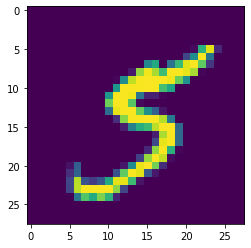

In [14]:
x1s = target(N)
plt.imshow(x1s[0].reshape(dim_MNIST,dim_MNIST).cpu())
del x1s

#### Running the Training

We are now ready to train our model. Let's build a loop that runs for `n_opt` stepsand store the loss over time.

In [15]:
%%time
Load = True
warm_up = True
if not Load:
    b = VelocityFieldImage(init_features=dim_MNIST, device=device)
    if warm_up:
        b.load_state_dict(torch.load("./data/weight_UNET_MNIST_alpha.pth"))
    print("This model has", sum(p.numel() for p in b.parameters()), "parameters.")
    lr = 3e-4
    weight_decay = 0.1
    n_opt = 20
    scaler = amp.GradScaler()
    opt = torch.optim.AdamW(b.parameters(), lr = lr, weight_decay = weight_decay)
    sched = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.991)
    # sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, n_opt)
    losses = []
    losses_eval = []
    from tqdm import tqdm
    pbar = tqdm(range(n_opt))
    for i in pbar:
        
        res = train_step(b, interpolant, opt, sched, scaler)
        
        loss = res['loss'].to('cpu').detach().numpy().mean()
        loss_v = res['loss_eval'].to('cpu').detach().numpy().mean()
        
        losses.append(loss)
        losses_eval.append(loss_v)
        pbar.set_description(f'Loss: {loss:.4f}, Loss eval: {loss_v: .4f}')

        if i%50 == 0:
            print(f"### Epoch {i+1}")
            print(f"The learning rate is {opt.param_groups[0]['lr']}")
            print(f"Cumulated mean train loss is {sum(losses)/len(losses)}")
    
    torch.save(b.state_dict(), "../data/weight_UNET_MNIST_alpha.pth")
    plt.plot(losses)
    plt.plot(losses_eval)
    
if Load:
    b = VelocityFieldImage(init_features=dim_MNIST, device=device)
    b.load_state_dict(torch.load("../data/weight_UNET_MNIST_alpha_1.pth"))
    b.eval()

CPU times: user 2.89 s, sys: 1.47 s, total: 4.37 s
Wall time: 4.38 s


## Full Generation

In [16]:
ode  = ODE(b, interpolant, n_step = 80, Alpha = None, device = device)

x_init = base.sample(1).to(device)
xfs = ode.solve(x_init)
x1s = xfs[-1].detach().cpu().numpy()
x1s = (x1s.clip(-1, 1) + 1)/2
del x_init; del xfs

# SDE

Another equivalent approach to sample from $\rho_1$ is to solve the SDE, noting $W_t$ the standard Wiener process and $\epsilon$ a positive constant parameter:
$$
\begin{array}{ll}
dx_t&=b_t(X_t)dt + \sqrt{2\epsilon \alpha_t}dW_t + \epsilon(x + (1-\alpha_t)b_t(x_t))dt, \\
x(0)&=x_0 \sim \rho_0.
\end{array}
$$

instead of the ODE:
$$
\begin{array}{ll}
\dot{x}_t&=b_t(X_t), \\
x(0)&=x_0 \sim \rho_0.
\end{array}
$$

A variable `mask` is introduced to ensure that masked pixels do not evolve during sampling.

In [20]:
class Interpolant:        
    def _single_xt(self, x0, x1, alpha):
        if len(alpha.shape) != len(x0.shape):
            alpha = alpha.reshape(*x0.shape)
        return alpha*x0 + (1 - alpha)*x1
        
    def alpha(self, alpha):
        return alpha
        
    def dotalpha(self, alpha):
        return -1.0 + 0*alpha
        
    def beta(self, alpha):
        return 1 - alpha
        
    def dotbeta(self, alpha):
        return 1.0 + 0*alpha
        
    def _single_dtxt(self, x0, x1):
        return x0 - x1
    
    def xt(self, x0, x1, alpha):
        if len(alpha.shape) != len(x0.shape):
            alpha = alpha.reshape(*x0.shape)
        return vmap(self._single_xt, in_dims=(0, 0, 0))(x0,x1,alpha)
    
    def dtxt(self, x0, x1):
        return vmap(self._single_dtxt, in_dims=(0, 0))(x0,x1)
    
interpolant = Interpolant()

In [21]:
class SDE:

    def __init__(self, b, interpolant, eps, n_step, Alpha = None, mask = None, device: str = device):
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        if Alpha is None:
            self.alpha       = torch.stack((torch.linspace(1.0,0.0, n_step + 1, device = device),)*dim, axis = 1)
        else:
            self.alpha = Alpha

        if mask is None:
            self.mask = torch.ones(self.alpha.shape[-1], device = device).reshape(dim_MNIST, dim_MNIST)
        else:
            self.mask = mask
            if mask.device != device:
                self.mask = mask.to(device)

        self.dt          = 1/n_step
        self.eps         = eps
        self.sqrtepsdt   = torch.sqrt(torch.tensor(2.0)*self.eps*self.dt)

        self.device = device

    def step(self, x, alpha):
        alpha_t = self.interpolant.alpha(alpha).reshape(-1, 1, dim_MNIST, dim_MNIST)
        gen = self.b(x, alpha)
        return x + (-gen*self.dt + torch.sqrt(alpha_t)*self.sqrtepsdt*torch.randn(x.size(), device = self.device) - self.eps*(x + (1 - alpha_t)*gen)*self.dt)*self.mask

    def solve(self, x_init: torch.Tensor) -> torch.Tensor:
        self.b.eval()
        xs = torch.zeros((self.n_step, *x_init.shape), device = device)
        x = x_init
        for i, alpha in enumerate(self.alpha[:-1]):
            alpha = alpha.repeat(len(x), 1) #Repeat for each batch size
            x = self.step(x, alpha)
            xs[i] = x
        return xs

eps = torch.tensor(0.7)
sde  = SDE(b, interpolant, eps = eps, n_step = 80, device = device)

In [22]:
x_init = base.sample(1).to(device)

xfs = sde.solve(x_init)
x2s = sde.solve(xfs[-1])[-1]

x1s = xfs[-1].detach().cpu().numpy()
x1s = (x1s.clip(-1, 1) + 1)/2

x2s = x2s.detach().cpu().numpy()
x2s = (x2s.clip(-1, 1) + 1)/2

del xfs; del x_init;

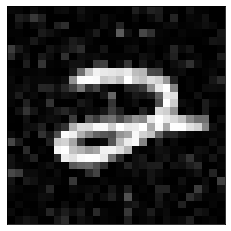

In [23]:
plt.imshow(x2s[0].reshape(dim_MNIST, dim_MNIST), cmap='gray')
plt.xticks([])
plt.yticks([])
# ax[i].set_title(f"$\epsilon = {eps:.2f}$")
# fig.suptitle("neural network with one alpha per pixel", fontsize=14)
plt.show()

### Block per block

In [74]:
n_step = 80

Alpha = torch.ones((n_step + 1, dim_MNIST, dim_MNIST), device = device)

x_init = base.sample(1).to(device)

mask1 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask1[:14, :14] = 1
Alpha1 = torch.clone(Alpha)
Alpha1[:, :14, :14] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 14, 14)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha1.reshape(n_step+1, dim), device = device, mask = mask1)
xfs = ode.solve(x_init)
xfs = ode.solve(xfs[-1])
x1s = xfs[-1]
del xfs; del x_init;

mask2 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask2[14:, :14] = 1
Alpha2 = torch.clone(Alpha)
Alpha2[:, 14:, :14] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 14, 14)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha2.reshape(n_step+1, dim), device = device, mask = mask2)
xfs = ode.solve(x1s)
xfs = ode.solve(xfs[-1])
x2s = xfs[-1]
del xfs;

mask3 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask3[:14, 14:] = 1
Alpha3 = torch.clone(Alpha)
Alpha1[:, :14, 14:] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 14, 14)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha3.reshape(n_step+1, dim), device = device, mask = mask3)
xfs = ode.solve(x2s)
xfs = ode.solve(xfs[-1])
x3s = xfs[-1]
del xfs;

mask4 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask4[14:, 14:] = 1
Alpha4 = torch.clone(Alpha)
Alpha4[:, 14:, 14:] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 14, 14)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha4.reshape(n_step+1, dim), device = device, mask = mask4)
xfs = ode.solve(x3s)
xfs = ode.solve(xfs[-1])
x4s = xfs[-1]
del xfs;

x1s = (x1s.clip(-1, 1) + 1)/2
x2s = (x2s.clip(-1, 1) + 1)/2
x3s = (x3s.clip(-1, 1) + 1)/2

x1s = x1s.detach().cpu()
x2s = x2s.detach().cpu()
x3s = x3s.detach().cpu()
x4s = x4s.detach().cpu()

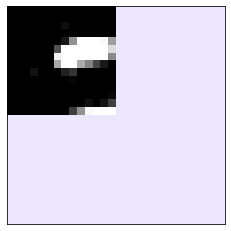

In [75]:

id_ = np.random.randint(0, 100000)

mask1 = torch.ones((dim_MNIST, dim_MNIST), device = device)
mask1[:14, :14] = 0
x1s = change_color(x1s, mask1)
plt.imshow(x1s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:quadrant_1")


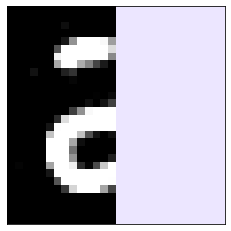

In [76]:
mask2 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask2[:, 14:] = 1
x2s = change_color(x2s, mask2)
plt.imshow(x2s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:quadrant_2")


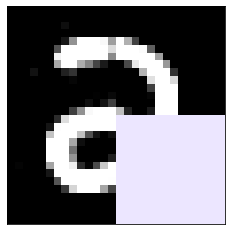

In [77]:
mask3 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask3[14:, 14:] = 1
x3s = change_color(x3s, mask3)
plt.imshow(x3s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:quadrant_3")


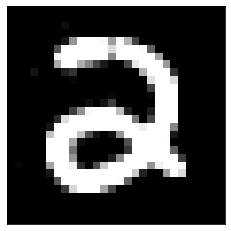

In [78]:
plt.imshow(((x4s[0].clip(-1, 1) + 1)/2).squeeze(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:quadrant_4")


In [96]:
n_step = 80

Alpha = torch.ones((n_step + 1, dim_MNIST, dim_MNIST), device = device)

x_init = base.sample(1).to(device)

mask1 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask1[:, :7] = 1
Alpha1 = torch.clone(Alpha)
Alpha1[:, :, :7] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 28, 7)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha1.reshape(n_step+1, dim), device = device, mask = mask1)
xfs = ode.solve(x_init)
xfs = ode.solve(xfs[-1])
x1s = xfs[-1]
del xfs; del x_init;

mask2 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask2[:, 7:14] = 1
Alpha2 = torch.clone(Alpha)
Alpha2[:, :, 7:14] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 28, 7)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha2.reshape(n_step+1, dim), device = device, mask = mask2)
xfs = ode.solve(x1s)
xfs = ode.solve(xfs[-1])
x2s = xfs[-1]
del xfs;

mask3 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask3[:, 14:21] = 1
Alpha3 = torch.clone(Alpha)
Alpha1[:, :, 14:21] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 28, 7)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha3.reshape(n_step+1, dim), device = device, mask = mask3)
xfs = ode.solve(x2s)
xfs = ode.solve(xfs[-1])
x3s = xfs[-1]
del xfs;

mask4 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask4[:, 21:] = 1
Alpha4 = torch.clone(Alpha)
Alpha4[:, :, 21:] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 28, 7)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha4.reshape(n_step+1, dim), device = device, mask = mask4)
xfs = ode.solve(x3s)
xfs = ode.solve(xfs[-1])
x4s = xfs[-1]
del xfs;

x1s = (x1s.clip(-1, 1) + 1)/2
x2s = (x2s.clip(-1, 1) + 1)/2
x3s = (x3s.clip(-1, 1) + 1)/2

x1s = x1s.detach().cpu()
x2s = x2s.detach().cpu()
x3s = x3s.detach().cpu()
x4s = x4s.detach().cpu()

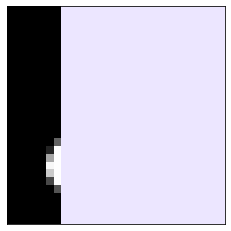

In [97]:
id_ = np.random.randint(0, 100000)

mask1 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask1[:, 7:] = 1
x1s = change_color(x1s, mask1)
plt.imshow(x1s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:16quadrants_1")


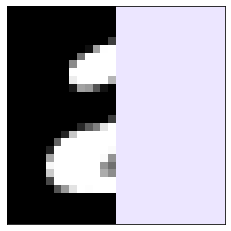

In [98]:
mask2 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask2[:, 14:] = 1
x2s = change_color(x2s, mask2)
plt.imshow(x2s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:16quadrants_2")


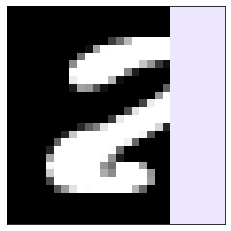

In [99]:
mask3 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask3[:, 21:] = 1
x3s = change_color(x3s, mask3)
plt.imshow(x3s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:16quadrants_3")


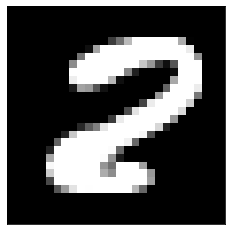

In [100]:
plt.imshow(((x4s[0].clip(-1, 1) + 1)/2).squeeze(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:16quadrants_4")


In [122]:
n_step = 80

Alpha = torch.ones((n_step + 1, dim_MNIST, dim_MNIST), device = device)

x_init = base.sample(1).to(device)

mask1 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask1[:7, :] = 1
Alpha1 = torch.clone(Alpha)
Alpha1[:, :7, :] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 7, 28)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha1.reshape(n_step+1, dim), device = device, mask = mask1)
xfs = ode.solve(x_init)
xfs = ode.solve(xfs[-1])
x1s = xfs[-1]
del xfs; del x_init;

mask2 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask2[7:14, :] = 1
Alpha2 = torch.clone(Alpha)
Alpha2[:, 7:14, :] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 7, 28)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha2.reshape(n_step+1, dim), device = device, mask = mask2)
xfs = ode.solve(x1s)
xfs = ode.solve(xfs[-1])
x2s = xfs[-1]
del xfs;

mask3 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask3[14:21, :] = 1
Alpha3 = torch.clone(Alpha)
Alpha1[:, 14:21, :] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 7, 28)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha3.reshape(n_step+1, dim), device = device, mask = mask3)
xfs = ode.solve(x2s)
xfs = ode.solve(xfs[-1])
x3s = xfs[-1]
del xfs;

mask4 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask4[21:, :] = 1
Alpha4 = torch.clone(Alpha)
Alpha4[:, 21:, :] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, 7, 28)
ode  = ODE(b, interpolant, n_step = 80, Alpha = Alpha4.reshape(n_step+1, dim), device = device, mask = mask4)
xfs = ode.solve(x3s)
xfs = ode.solve(xfs[-1])
x4s = xfs[-1]
del xfs;

x1s = (x1s.clip(-1, 1) + 1)/2
x2s = (x2s.clip(-1, 1) + 1)/2
x3s = (x3s.clip(-1, 1) + 1)/2

x1s = x1s.detach().cpu()
x2s = x2s.detach().cpu()
x3s = x3s.detach().cpu()
x4s = x4s.detach().cpu()

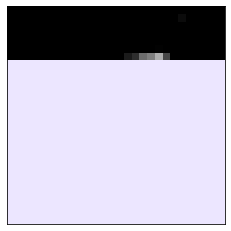

In [ ]:
id_ = np.random.randint(0, 100000)

mask1 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask1[7:, :] = 1
x1s = change_color(x1s, mask1)
plt.imshow(x1s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:16quadrants_up_1")

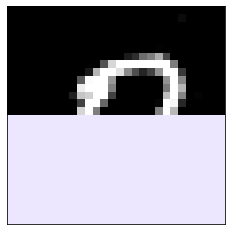

In [124]:
mask2 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask2[14:, :] = 1
x2s = change_color(x2s, mask2)
plt.imshow(x2s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:16quadrants_up_2")

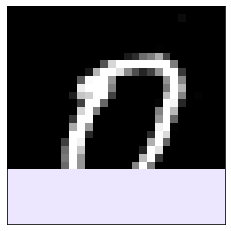

In [125]:
mask3 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask3[21:, :] = 1
x3s = change_color(x3s, mask3)
plt.imshow(x3s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:16quadrants_up_3")

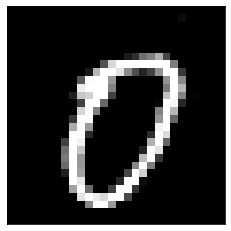

In [126]:
plt.imshow(((x4s[0].clip(-1, 1) + 1)/2).squeeze(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig(f"../Figures/alpha_per_pixel/{id_}:16quadrants_up_4")

In [ ]:
n_step = 80

Alpha = torch.ones((n_step + 1, dim_MNIST, dim_MNIST), device = device)

x_init = base.sample(1).to(device)

mask1 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask1[:14, :] = 1
Alpha1 = torch.clone(Alpha)
Alpha1[:, :14, :] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, dim_MNIST//2, dim_MNIST)
sde  = SDE(b, interpolant, n_step = 80, Alpha = Alpha1.reshape(n_step+1, dim), device = device, mask = mask1)
xfs = sde.solve(x_init)
x1s = xfs[-1]
del xfs; del x_init;

mask2 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask2[14:, :] = 1
Alpha2 = torch.clone(Alpha)
Alpha2[:, 14:, :] = torch.linspace(1., 0, n_step + 1, device = device)[:,None,None].repeat(1, dim_MNIST//2, dim_MNIST)
sde  = SDE(b, interpolant, n_step = 80, Alpha = Alpha2.reshape(n_step+1, dim), device = device, mask = mask2)
xfs = sde.solve(x1s)
x2s = xfs[-1]
del xfs;


x1s = (x1s.clip(-1, 1) + 1)/2
x2s = (x2s.clip(-1, 1) + 1)/2

x1s = x1s.detach().cpu()
x2s = x2s.detach().cpu()


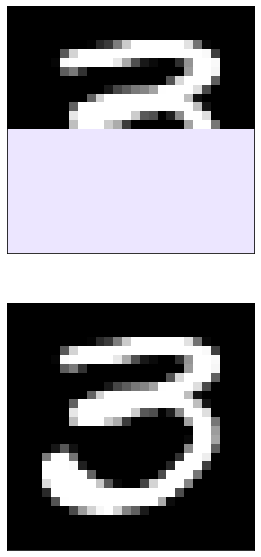

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(25,10))

mask1 = torch.ones((dim_MNIST, dim_MNIST), device = device)
mask1[:14, :] = 0
x1s = change_color(x1s, mask1)
axes[0,].imshow(x1s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
axes[0,].set_xticks([])
axes[0].set_yticks([])

mask2 = torch.zeros((dim_MNIST, dim_MNIST), device = device)
x2s = change_color(x2s, mask2)
axes[1].imshow(x2s[0].squeeze().permute(1,2,0).numpy(), cmap='gray')
axes[1].set_xticks([])
axes[1].set_yticks([])

del x1s; del x2s;

## Inpainting

In [144]:
#Declare the solver
n_step = 80

#Parameters
emb_dim = dim_MNIST*dim_MNIST
mid = (14, 14)
half_width = 7
half_length = 7
size_box = 2*half_width * 2*half_length
alpha_box = torch.stack((torch.linspace(1.0, 0, n_step + 1, device = device),)*size_box, axis = 1).reshape(n_step+1, 2*half_width, 2*half_length)
Alpha = torch.zeros((n_step+1, dim_MNIST, dim_MNIST), device = device)
Alpha[:, mid[0] - half_width : mid[0] + half_width, mid[1] - half_length: mid[1] + half_length] = alpha_box

mask = torch.zeros(*Alpha[0].shape, device = device)
mask[mid[0] - half_width : mid[0] + half_width, mid[1] - half_length: mid[1] + half_length] = 1

Alpha = Alpha.reshape(n_step+1, dim_MNIST*dim_MNIST)

sde  = SDE(b, interpolant, n_step = n_step, Alpha = Alpha, device = device, mask = mask, eps = eps)


x_init = base.sample(1).to(device)
x = target(1)
x_corr = x.clone() #Shallow copy
x_corr[:, :, mid[0] - half_width : mid[0] + half_width, mid[1] - half_length: mid[1] + half_length] = x_init[:, :, mid[0] - half_width : mid[0] + half_width, mid[1] - half_length: mid[1] + half_length]

xfs    = sde.solve(x_corr)
x2s = sde.solve(xfs[-1])[-1]

x1s = xfs[-1].detach().cpu().numpy()
x1s = (x1s.clip(-1, 1) + 1)/2

x2s = x2s.detach().cpu().numpy()
x2s = (x2s.clip(-1, 1) + 1)/2

del x_init; del xfs

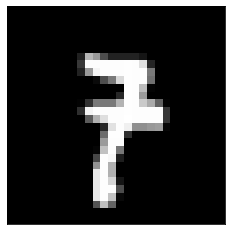

In [ ]:
save = True

id_ = np.random.randint(0, 100000)

plt.imshow(x.cpu().numpy().squeeze(), cmap = 'gray')
# plt.title("Original")
plt.xticks([])
plt.yticks([])

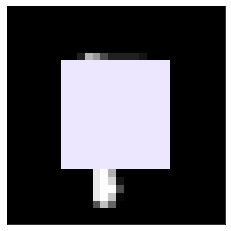

In [ ]:
x_test = (x_corr.cpu().clip(-1, 1) + 1)/2
x_test = change_color(x_test, mask)
plt.imshow(x_test.squeeze().permute(1,2,0).numpy(), cmap = 'gray')
plt.xticks([])
plt.yticks([])

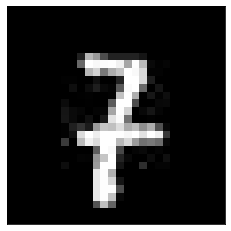

In [ ]:
plt.imshow(x2s[0].reshape(dim_MNIST, dim_MNIST), cmap='gray')
plt.xticks([])
plt.yticks([])

In [35]:
#Declare the solver
n_step = 80

#Parameters
emb_dim = dim_MNIST*dim_MNIST
pixel_noise = 300
Index = torch.randint(0, dim, (pixel_noise,))
Alpha = torch.zeros((n_step+1, dim_MNIST * dim_MNIST), device = device)
Alpha[:,Index] = torch.stack((torch.linspace(1., 0, n_step + 1, device = device),)*pixel_noise, axis = 1)

mask = torch.zeros(*Alpha[0].shape, device = device)
mask[Index] = 1
mask = mask.reshape(dim_MNIST, dim_MNIST)

sde  = SDE(b, interpolant, n_step = n_step, Alpha = Alpha, device = device, mask = mask, eps = eps)

x_init = base.sample(1).to(device).reshape(1, 1, dim_MNIST*dim_MNIST)
x = target(1).reshape(1, 1, dim_MNIST*dim_MNIST)

x_corr = x.clone() #Shallow copy
x_corr[:, :, Index] = x_init[:, :, Index]
x_corr = x_corr.reshape(1, 1, dim_MNIST, dim_MNIST)

xfs    = sde.solve(x_corr)
x2s = sde.solve(xfs[-1])[-1]

x1s = xfs[-1].detach().cpu().numpy()
x1s = (x1s.clip(-1, 1) + 1)/2

x2s = x2s.detach().cpu().numpy()
x2s = (x2s.clip(-1, 1) + 1)/2

del x_init; del xfs
x = x.reshape(1, 1, dim_MNIST, dim_MNIST)

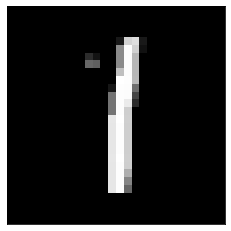

In [ ]:
save = False

id_ = np.random.randint(0, 100000)

plt.imshow(x.cpu().numpy().squeeze(), cmap = 'gray')
plt.xticks([])
plt.yticks([])

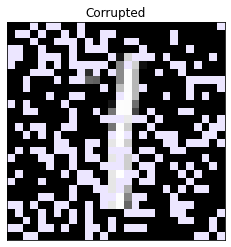

In [ ]:
x_test = (x_corr.cpu().clip(-1, 1) + 1)/2
x_test = change_color(x_test, mask)
plt.imshow(x_test.squeeze().permute(1,2,0).numpy(), cmap = 'gray')
plt.xticks([])
plt.yticks([])

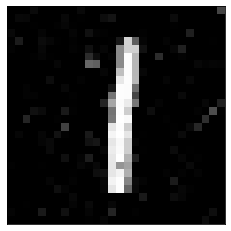

In [ ]:
plt.imshow(x2s[0].reshape(dim_MNIST, dim_MNIST), cmap='gray')
# axes[2].set_title("Stochastic Interpolant")
plt.xticks([])
plt.yticks([])

### Download the mask

In [166]:
nb = 3
with open(f"../mask {nb}", "rb") as f:
    Idx_mask = pkl.load(f)

n_step = 80

mask = torch.zeros((dim_MNIST, dim_MNIST), device = device)
mask[Idx_mask[0], Idx_mask[1]] = 1
Alpha = torch.zeros((n_step + 1, dim_MNIST, dim_MNIST), device = device)
Alpha[:,Idx_mask[0], Idx_mask[1]] = torch.stack((torch.linspace(1., 0, n_step + 1, device = device),)*len(Idx_mask[0]), axis = 1)
Alpha = Alpha.reshape(-1, dim_MNIST*dim_MNIST)

sde = SDE(b, interpolant, device = device, n_step = n_step, Alpha = Alpha, mask = mask, eps = eps)

x_init = base.sample(1).to(device)
x = target(1).reshape(1, 1, dim_MNIST, dim_MNIST)
x_corr = x.clone() #Shallow copy
x_corr[:, :, Idx_mask[0], Idx_mask[1]] = x_init[:, :, Idx_mask[0], Idx_mask[1]]

xfs    = sde.solve(x_corr)
x2s = sde.solve(xfs[-1])[-1]
x1s = xfs[-1].detach().cpu().numpy()
x1s = (x1s.clip(-1, 1) + 1)/2

x2s = x2s.detach().cpu().numpy()
x2s = (x2s.clip(-1, 1) + 1)/2

del x_init; del xfs

x = x.reshape(1, 1, dim_MNIST, dim_MNIST)

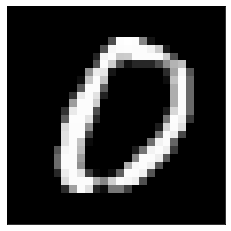

In [ ]:
save = True

id_ = np.random.randint(0, 100000)

plt.imshow(x.cpu().numpy().squeeze(), cmap = 'gray')
plt.xticks([])
plt.yticks([])

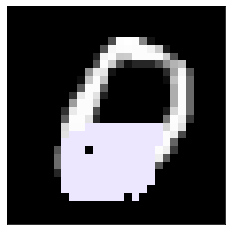

In [ ]:
x_test = (x_corr.cpu().clip(-1, 1) + 1)/2
x_test = change_color(x_test, mask)
plt.imshow(x_test.squeeze().permute(1,2,0).numpy(), cmap = 'gray')
# plt.title("Corrupted")
plt.xticks([])
plt.yticks([])

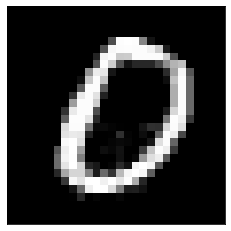

In [ ]:
plt.imshow(x2s[0].reshape(dim_MNIST, dim_MNIST), cmap='gray')
# axes[2].set_title("Stochastic Interpolant")
plt.xticks([])
plt.yticks([])

### Grid mask

In [43]:
#Declare the solver
n_step = 80

#Parameters
emb_dim = dim_MNIST*dim_MNIST
Alpha = torch.zeros((n_step+1, dim_MNIST, dim_MNIST), device = device)
Idx = range(0, 28, 2)
Alpha[:, Idx, :] = torch.stack((torch.linspace(1, 0, n_step + 1, device = device),)*len(Idx), axis = 1)[:,:,None].repeat(1, 1, 28)

mask = torch.zeros(*Alpha[0].shape, device = device)
mask[Idx, :] = 1

Alpha = Alpha.reshape(n_step+1, dim_MNIST*dim_MNIST)

sde  = SDE(b, interpolant, n_step = n_step, Alpha = Alpha, device = device, mask = mask, eps = eps)


x_init = base.sample(1).to(device)
x = target(1)
x_corr = x.clone() #Shallow copy
x_corr[:,:, Idx, :] = x_init[:, :, Idx, :]

xfs    = sde.solve(x_corr)
x2s = sde.solve(xfs[-1])[-1]

x1s = xfs[-1].detach().cpu().numpy()
x1s = (x1s.clip(-1, 1) + 1)/2

x2s = x2s.detach().cpu().numpy()
x2s = (x2s.clip(-1, 1) + 1)/2

del x_init; del xfs

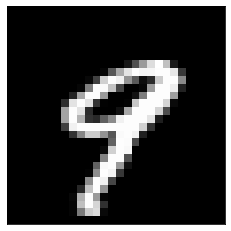

In [44]:
save = False

id_ = np.random.randint(0, 100000)

plt.imshow(x.cpu().numpy().squeeze(), cmap = 'gray')
plt.xticks([])
plt.yticks([])
if save:
    plt.savefig(f"../Figures/SDE/alpha_per_pixel/inpainting_grid/Original_{id_}")

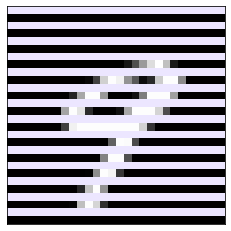

In [45]:
x_test = (x_corr.cpu().clip(-1, 1) + 1)/2
x_test = change_color(x_test, mask)
plt.imshow(x_test.squeeze().permute(1,2,0).numpy(), cmap = 'gray')
# plt.title("Corrupted")
plt.xticks([])
plt.yticks([])

if save:
    plt.savefig(f"../Figures/SDE/alpha_per_pixel/inpainting_grid/Corrupted_{id_}")

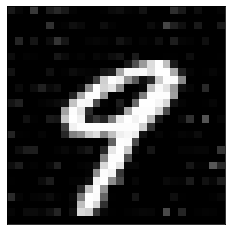

In [46]:
plt.imshow(x2s[0].reshape(dim_MNIST, dim_MNIST), cmap='gray')
# axes[2].set_title("Stochastic Interpolant")
plt.xticks([])
plt.yticks([])

if save:
    plt.savefig(f"../Figures/SDE/alpha_per_pixel/inpainting_grid/S_interpolant_{id_}")

In [47]:
#Declare the solver
n_step = 80

#Parameters
emb_dim = dim_MNIST*dim_MNIST
Alpha = torch.zeros((n_step+1, dim_MNIST, dim_MNIST), device = device)
Idx = range(0, 28, 2)
Alpha[:, :, Idx] = torch.stack((torch.linspace(1, 0, n_step + 1, device = device),)*dim_MNIST, axis = 1)[:,:,None].repeat(1, 1, len(Idx))
Alpha[:, Idx, :] = torch.stack((torch.linspace(1, 0, n_step + 1, device = device),)*len(Idx), axis = 1)[:,:,None].repeat(1, 1, dim_MNIST)


mask = torch.zeros(*Alpha[0].shape, device = device)
mask[:, Idx] = 1
mask[Idx, :] = 1


Alpha = Alpha.reshape(n_step+1, dim_MNIST*dim_MNIST)

sde  = SDE(b, interpolant, n_step = n_step, Alpha = Alpha, device = device, mask = mask, eps = eps)


x_init = base.sample(1).to(device)
x = target(1)
x_corr = x.clone() #Shallow copy
x_corr[:,:, :, Idx] = x_init[:, :, :, Idx]

xfs    = sde.solve(x_corr)
x2s = sde.solve(xfs[-1])[-1]

x1s = xfs[-1].detach().cpu().numpy()
x1s = (x1s.clip(-1, 1) + 1)/2

x2s = x2s.detach().cpu().numpy()
x2s = (x2s.clip(-1, 1) + 1)/2

del x_init; del xfs

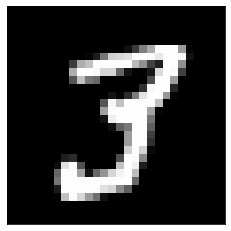

In [48]:
save = False

id_ = np.random.randint(0, 100000)

plt.imshow(x.cpu().numpy().squeeze(), cmap = 'gray')
plt.xticks([])
plt.yticks([])
if save:
    plt.savefig(f"../Figures/SDE/alpha_per_pixel/inpainting_grid/Original_{id_}")

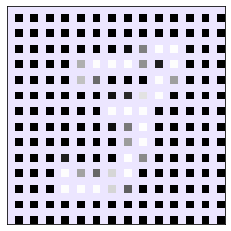

In [49]:
x_test = (x_corr.cpu().clip(-1, 1) + 1)/2
x_test = change_color(x_test, mask)
plt.imshow(x_test.squeeze().permute(1,2,0).numpy(), cmap = 'gray')
# plt.title("Corrupted")
plt.xticks([])
plt.yticks([])

if save:
    plt.savefig(f"../Figures/SDE/alpha_per_pixel/inpainting_grid/Corrupted_{id_}")

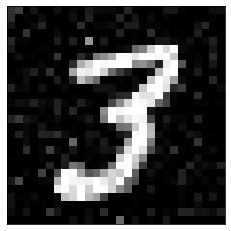

In [50]:
plt.imshow(x2s[0].reshape(dim_MNIST, dim_MNIST), cmap='gray')
# axes[2].set_title("Stochastic Interpolant")
plt.xticks([])
plt.yticks([])

if save:
    plt.savefig(f"../Figures/SDE/alpha_per_pixel/inpainting_grid/S_interpolant_{id_}")

## Check boarder

In [190]:
Idx = torch.tensor([0, 1, 2, 3] + [8, 9, 10, 11] + [15, 16, 17, 18] + [22, 23, 24, 25], device = device)
grid_x, grid_y = torch.meshgrid(Idx, Idx, indexing='ij')
#Declare the solver
n_step = 80

#Parameters
emb_dim = dim_MNIST*dim_MNIST
Alpha = torch.zeros((n_step+1, dim_MNIST, dim_MNIST), device = device)
Alpha[:, grid_x, grid_y] = torch.stack((torch.linspace(1, 0, n_step + 1, device = device),)*16, axis = 1)[:,:,None].repeat(1, 1, 16)

mask = torch.zeros(*Alpha[0].shape, device = device)
mask[grid_x, grid_y] = 1

Alpha = Alpha.reshape(n_step+1, dim_MNIST*dim_MNIST)

sde  = SDE(b, interpolant, n_step = n_step, Alpha = Alpha, device = device, mask = mask, eps = eps)

x_init = base.sample(1).to(device)
x = target(1)
x_corr = x.clone() #Shallow copy
x_corr[:,:, grid_x, grid_y] = x_init[:, :, grid_x, grid_y]

xfs    = sde.solve(x_corr)
x2s = sde.solve(xfs[-1])[-1]
x3s = sde.solve(x2s)[-1]

x1s = xfs[-1].detach().cpu().numpy()
x1s = (x1s.clip(-1, 1) + 1)/2

x3s = x3s.detach().cpu().numpy()
x3s = (x3s.clip(-1, 1) + 1)/2

del x_init; del xfs

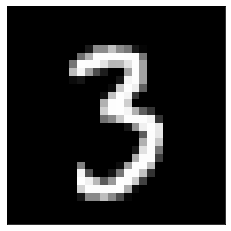

In [191]:
save = True

id_ = np.random.randint(0, 100000)

plt.imshow(x.cpu().numpy().squeeze(), cmap = 'gray')
plt.xticks([])
plt.yticks([])
if save:
    plt.savefig(f"../Figures/alpha_per_pixel/Inpainting/Checker/{id_}:Original")

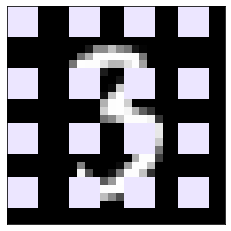

In [192]:
x_test = (x_corr.cpu().clip(-1, 1) + 1)/2
x_test = change_color(x_test, mask)
plt.imshow(x_test.squeeze().permute(1,2,0).numpy(), cmap = 'gray')
# plt.title("Corrupted")
plt.xticks([])
plt.yticks([])

if save:
    plt.savefig(f"../Figures/alpha_per_pixel/Inpainting/Checker/{id_}:Corrupted")

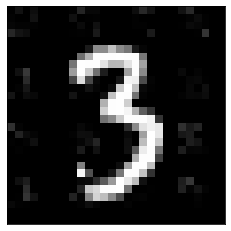

In [194]:
plt.imshow(x3s[0].reshape(dim_MNIST, dim_MNIST), cmap='gray')
# axes[2].set_title("Stochastic Interpolant")
plt.xticks([])
plt.yticks([])

if save:
    plt.savefig(f"../Figures/alpha_per_pixel/Inpainting/Checker/{id_}:S_interpolant")